In [22]:
import pandas as pd
from collections import Counter
import requests
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams["svg.fonttype"] = "none" 
import seaborn as sns
from collections import defaultdict
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import math
import matplotlib.pyplot as plt
import ast
import matplotlib.ticker as mtick
from scipy.stats import ttest_ind
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, Normalize   
import squarify

In [23]:
masterfile = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/masterfile/all_smOOPS_and_controls_V2.tsv', sep='\t')
masterfile

,chr,start,end,gene_id,feature,strand,gene_name,transcript_id,feature_length,smoops_naive,smoops_epi,smoops_diff,control_common,semi_diff_mean_tpm,semi_epiSC_mean_tpm,semi_naive_mean_tpm,semi_diff_mean_count,semi_epiSC_mean_count,semi_naive_mean_count
0,chr1,3284704,3741721,ENSMUSG00000051951.6,transcript,-,Xkr4,ENSMUST00000070533.5,457017,False,True,True,False,3.872970,2.324972,0.014051,194.333000,235.666667,0.666667
1,chr1,3435953,3438772,ENSMUSG00000103377.2,transcript,-,Gm37180,ENSMUST00000195335.2,2819,False,True,True,False,0.521827,0.301747,0.012481,22.666667,26.666667,0.333333
2,chr1,3445778,3448011,ENSMUSG00000104017.2,transcript,-,Gm37363,ENSMUST00000192336.2,2233,False,False,True,False,0.485116,0.206451,0.000000,14.333333,15.666667,0.000000
3,chr1,3535199,3537508,ENSMUSG00000103025.2,transcript,-,Gm37686,ENSMUST00000194099.2,2309,False,False,True,False,0.627143,0.321620,0.000000,18.000000,24.666667,0.000000
4,chr1,3582673,3584730,ENSMUSG00000103201.2,transcript,-,Gm37329,ENSMUST00000192973.2,2057,False,False,True,False,1.040409,0.393665,0.000000,30.333333,25.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,chrX,160616291,160942726,ENSMUSG00000059493.14,transcript,-,Nhs,ENSMUST00000087085.10,326435,False,True,True,False,0.707368,0.917609,0.077997,91.000000,245.000000,6.000000
3056,chrX,165173028,165223700,ENSMUSG00000040586.9,transcript,-,Ofd1,ENSMUST00000049501.9,50672,False,True,True,False,2.596442,2.308879,1.399653,165.333333,326.725000,86.666667
3057,chrX,168094525,168103276,ENSMUSG00000031352.11,transcript,-,Hccs,ENSMUST00000033717.9,8751,False,False,False,True,8.779636,9.323919,9.318443,270.333333,630.333333,302.000333
3058,chrY,1260770,1286629,ENSMUSG00000069045.12,transcript,-,Ddx3y,ENSMUST00000091190.12,25859,False,True,True,False,12.061610,9.830595,1.813766,633.994667,1141.029333,96.344667


In [24]:
clusters = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Results/machine_learning_results/cluster_assignment_file/cluster_of_all_model.tsv', sep="\t")
clusters

,transcript_id,Cluster
0,ENSMUST00000000199.8,0
1,ENSMUST00000000291.9,0
2,ENSMUST00000000312.12,0
3,ENSMUST00000000314.13,0
4,ENSMUST00000000642.11,0
...,...,...
1819,ENSMUST00000239449.2,0
1820,ENSMUST00000239483.2,0
1821,ENSMUST00000239525.1,0
1822,ENSMUST00000239527.1,0


In [25]:
all_expressed_cds = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/smOOPS_paper/Data/sequences_of_all_expressed_genes/all_expressed_genes_with_fasta_collapsed_and_with_preds_and_cds.bed', sep="\t")
all_expressed_cds_with_clusters = pd.merge(all_expressed_cds, clusters, on='transcript_id', how='left')
all_expressed_cds_with_clusters_stages = pd.merge(all_expressed_cds_with_clusters, masterfile[["gene_id", "smoops_naive",	"smoops_epi",	"smoops_diff"]], on='gene_id', how='left')

all_expressed_cds_with_clusters_stages['smoops_naive'] = all_expressed_cds_with_clusters_stages['smoops_naive'].fillna(False)
all_expressed_cds_with_clusters_stages['smoops_epi'] = all_expressed_cds_with_clusters_stages['smoops_epi'].fillna(False)
all_expressed_cds_with_clusters_stages['smoops_diff'] = all_expressed_cds_with_clusters_stages['smoops_diff'].fillna(False)
all_expressed_cds_with_clusters_stages['control_all'] = all_expressed_cds_with_clusters_stages['Cluster'].isna()
all_expressed_cds_with_clusters_stages['smoops_all'] = ~all_expressed_cds_with_clusters_stages['control_all']
all_expressed_cds_with_clusters_stages = all_expressed_cds_with_clusters_stages[all_expressed_cds_with_clusters_stages['cds_sequence'] != "Not Found"]
all_expressed_cds_with_clusters_stages['control_all'].value_counts()

/tmp/ipykernel_181741/171969095.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_expressed_cds_with_clusters_stages['smoops_naive'] = all_expressed_cds_with_clusters_stages['smoops_naive'].fillna(False)
/tmp/ipykernel_181741/171969095.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_expressed_cds_with_clusters_stages['smoops_epi'] = all_expressed_cds_with_clusters_stages['smoops_epi'].fillna(False)
/tmp/ipykernel_181741/171969095.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in

control_all
True     10570
False     1264
Name: count, dtype: int64

In [26]:
codon_to_amino_acid = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

def count_codons(row):

    cds_sequence = row['cds_sequence'][3:]
    excess_length = len(cds_sequence) % 3
    if excess_length != 0:
        cds_sequence = cds_sequence[:-excess_length]

    total_codons = len(cds_sequence) // 3
    codon_counts = Counter([cds_sequence[i:i+3] for i in range(0, len(cds_sequence), 3)])

    normalized_codon_counts = {codon: count / total_codons for codon, count in codon_counts.items()}
    for codon in codon_to_amino_acid:
        if codon not in normalized_codon_counts:
            normalized_codon_counts[codon] = 0
    return normalized_codon_counts

all_expressed_cds_with_clusters_stages['normalized_codon_counts'] = all_expressed_cds_with_clusters_stages.apply(count_codons, axis=1)

all_expressed_cds_with_clusters_stages['Cluster'] = all_expressed_cds_with_clusters_stages['Cluster'].fillna("Control")
all_expressed_cds_with_clusters_stages

,gene_id,transcript_id,strand,gene_name,feature_length,sequence,sequence_length,prediction_class_1,is_predicted_as_smoops,cds_sequence,Cluster,smoops_naive,smoops_epi,smoops_diff,control_all,smoops_all,normalized_codon_counts
0,ENSMUSG00000000001.5,ENSMUST00000000001.5,-,Gnai3,259,CACACATCCGGTTCTTCCGGGAGCTAGGGGAGCTGACGGAGAAGGC...,3262,0.064351,False,ATGGGCTGCACGTTGAGCGCCGAGGACAAGGCGGCGGTGGAGCGGA...,Control,False,False,False,True,False,"{'GGC': 0.01977401129943503, 'TGC': 0.00847457..."
1,ENSMUSG00000020875.10,ENSMUST00000000010.9,+,Hoxb9,602,GGTCCGTGTGCCACCTTTTCCCTGCTTGGGCGCCGCGGCGCGAGCG...,2574,0.546328,True,ATGTCCATTTCTGGGACGCTTAGCAGCTATTATGTCGACTCGATCA...,Control,False,False,False,True,False,"{'TCC': 0.012, 'ATT': 0.008, 'TCT': 0.02, 'GGG..."
2,ENSMUSG00000000028.16,ENSMUST00000000028.14,-,Cdc45,169,TGGAAACACATTCAAATAATGTGTGACTGAATTTACTTTATGTCTA...,2143,0.199400,False,ATGTTCGTGACCGATTTCCGCAAGGAGTTCTACGAGACGGTCCACA...,Control,False,False,False,True,False,"{'TTC': 0.02120141342756184, 'GTG': 0.03710247..."
3,ENSMUSG00000048583.17,ENSMUST00000000033.12,-,Igf2,109,GGCACTGACCAGTTCGCAAACTGGACATTAGCTTCTCCTGTGAGAA...,3708,0.950019,True,ATGGGGATCCCAGTGGGGAAGTCGATGTTGGTGCTTCTCATCTCTT...,Control,False,False,False,True,False,"{'GGG': 0.022222222222222223, 'ATC': 0.0277777..."
4,ENSMUSG00000000058.7,ENSMUST00000000058.7,+,Cav2,326,GGGGTTCGGCCAGCCAAGGCTGGGAGCGGGAACCGGCAGCGGGAAG...,2733,0.153074,False,ATGGGGCTGGAGACCGAGAAGGCCGATGTGCAGCTCTTCATGGCCG...,Control,False,False,False,True,False,"{'GGG': 0.006172839506172839, 'CTG': 0.0493827..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16383,ENSMUSG00000118665.1,ENSMUST00000239512.1,-,Lin54,134,CGGCGGTGGAATGGCGCTGGGCGCGTGATTTTGAACAAACCCGGGT...,4451,0.509317,True,ATGGAGGTGGTGCCGGCCGAGGTGAATAGTTTGCTTCCAGACGACA...,Control,False,False,False,True,False,"{'GAG': 0.02403204272363151, 'GTG': 0.02937249..."
16385,ENSMUSG00000118667.1,ENSMUST00000239525.1,-,Ahnak2,186,GTCACAACCCGGCTGCCCGCGGCAGCACCGGGCAGCGAGGCCGTGG...,11349,0.998312,True,ATGTGCGACTGCTTCCACGTGGTGTTGCCCACCTGGCCCGGAGCCC...,0.0,False,True,True,False,True,"{'TGC': 0.001999428734647244, 'GAC': 0.0525564..."
16386,ENSMUSG00000118668.1,ENSMUST00000239527.1,-,Rps6ka4,144,CACCAGGAAGCACCCGCCCCGGCCGGAGCCGCCATGTAACCGGCGC...,3140,0.729938,True,ATGGGAGACGAGGATGAGGACGAGGGCTGCGCCGTGGAGCTGCAGA...,0.0,False,True,False,False,True,"{'GGA': 0.01034928848641656, 'GAC': 0.02975420..."
16387,ENSMUSG00000118669.2,ENSMUST00000239538.1,+,Arvcf,124,GCCTGCACTGGAGGGAGTCAGTAGAGCCGGAGCGGCCGGAGCGCCC...,3829,0.890984,True,ATGCCGGCCGAACTCAGACAGGAGCAGAGCCCGGGTAGCCAGGCAT...,Control,False,False,False,True,False,"{'CCG': 0.005605381165919282, 'GCC': 0.0414798..."


/tmp/ipykernel_181741/2797267172.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['normalized_codon_counts'] = df['normalized_codon_counts'].apply(convert_to_dict)
/tmp/ipykernel_181741/2797267172.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aa_counts'] = df['normalized_codon_counts'].apply(


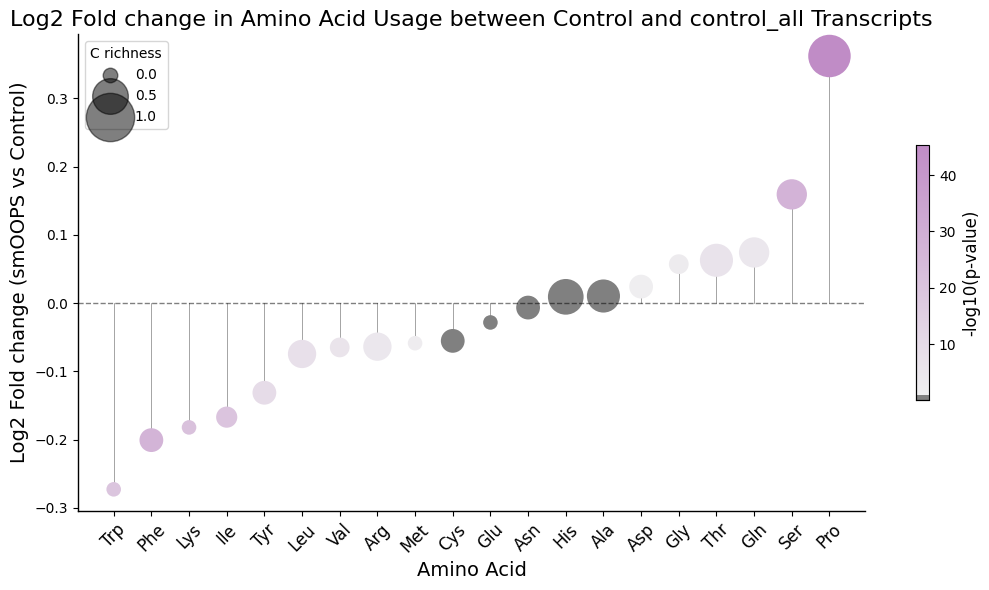

/tmp/ipykernel_181741/2797267172.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['normalized_codon_counts'] = df['normalized_codon_counts'].apply(convert_to_dict)
/tmp/ipykernel_181741/2797267172.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aa_counts'] = df['normalized_codon_counts'].apply(


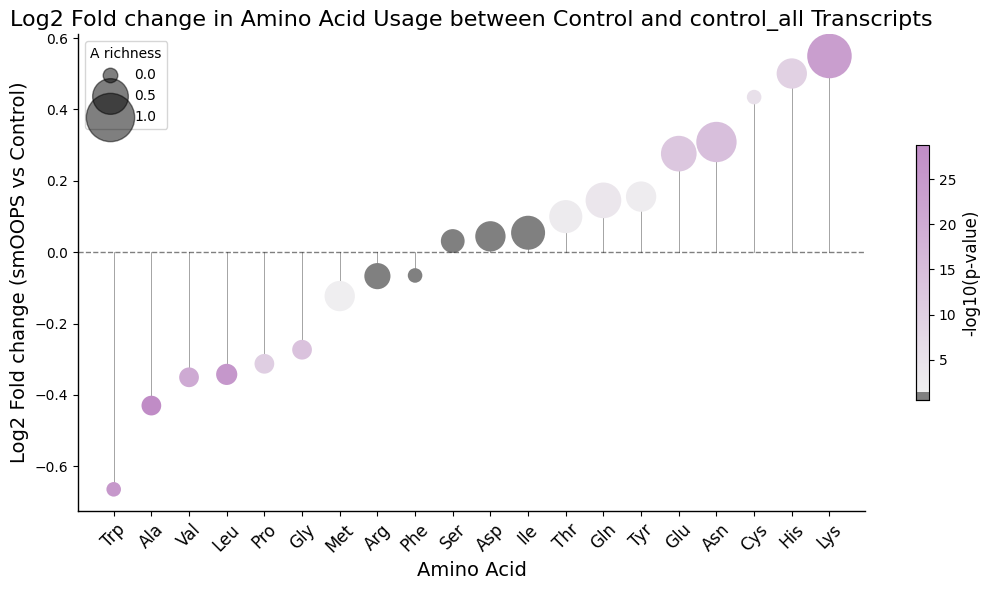

In [27]:
def convert_to_dict(x):

    if isinstance(x, str):
        return ast.literal_eval(x)
    else:
        return x

def create_codon_table():

    return {
        'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
        'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
        'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
        'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
        'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
        'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
        'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
        'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
        'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
        'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
        'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
        'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
        'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
        'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
        'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
        'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
    }


def create_amino_acid_conversion():

    return {
        'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp',
        'C': 'Cys', 'Q': 'Gln', 'E': 'Glu', 'G': 'Gly',
        'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys',
        'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser',
        'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'
    }


def codon_counts_to_aa_counts(codon_counts, codon_table, amino_acid_conversion):

    aa_counts = {}
    for codon, count in codon_counts.items():
        aa_single_letter = codon_table.get(codon)
        aa_three_letter = amino_acid_conversion.get(aa_single_letter)
        if aa_three_letter:
            aa_counts[aa_three_letter] = aa_counts.get(aa_three_letter, 0) + count
    return aa_counts


def sum_aa_counts(df_group):

    total_counts = Counter()
    for aa_counts in df_group['aa_counts']:
        total_counts.update(aa_counts)
    return total_counts


def plot_amino_acid_usage(df, group_col, nucleotide):

    df['normalized_codon_counts'] = df['normalized_codon_counts'].apply(convert_to_dict)

    codon_table = create_codon_table()
    amino_acid_conversion = create_amino_acid_conversion()

    amino_acid_nucleotide_count = {}
    for codon, aa_single_letter in codon_table.items():
        nucleotide_count = codon.count(nucleotide)

        if aa_single_letter not in amino_acid_nucleotide_count:
            amino_acid_nucleotide_count[aa_single_letter] = {'total_c': 0, 'codon_count': 0}

        amino_acid_nucleotide_count[aa_single_letter]['total_c'] += nucleotide_count
        amino_acid_nucleotide_count[aa_single_letter]['codon_count'] += 1

    average_nucleotide_per_amino_acid = {
        amino_acid_conversion.get(aa, aa): 
        amino_acid_nucleotide_count[aa]['total_c'] / (amino_acid_nucleotide_count[aa]['codon_count'] * 3)
        for aa in amino_acid_nucleotide_count
    }

    df['aa_counts'] = df['normalized_codon_counts'].apply(
        lambda x: codon_counts_to_aa_counts(x, codon_table, amino_acid_conversion)
    )

    group_true = df[df[group_col] == False]
    group_false = df[df[group_col] == True]

    aa_counts_true = sum_aa_counts(group_true)
    aa_counts_false = sum_aa_counts(group_false)

    total_counts_true = sum(aa_counts_true.values())
    total_counts_false = sum(aa_counts_false.values())

    freqs_true = {aa: count / total_counts_true for aa, count in aa_counts_true.items()}
    freqs_false = {aa: count / total_counts_false for aa, count in aa_counts_false.items()}

    all_amino_acids = set(freqs_true.keys()).union(set(freqs_false.keys()))

    data = []
    for aa in all_amino_acids:
        freq_true = freqs_true.get(aa, 0)
        freq_false = freqs_false.get(aa, 0)

        diff = np.log2(freq_true / (freq_false + 1e-10))

        true_values = group_true['aa_counts'].apply(lambda x: x.get(aa, 0))
        false_values = group_false['aa_counts'].apply(lambda x: x.get(aa, 0))

        t_stat, p_value = ttest_ind(true_values, false_values, equal_var=False)
        log_p_value = -np.log10(p_value)

        data.append({
            'AminoAcid': aa,
            'Freq_True': freq_true,
            'Freq_False': freq_false,
            'Difference': diff,
            '-log10(P-Value)': log_p_value
        })

    diff_df = pd.DataFrame(data)

    diff_df.sort_values('Difference', inplace=True)

    grey_cmap = LinearSegmentedColormap.from_list('grey_cmap', ['#808080', '#808080'], N=256)
    colors_for_cool = ['#EFEFF0', '#C08CC6']
    cool_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_for_cool, N=256)

    max_neg_log_p = diff_df['-log10(P-Value)'].max()
    grey_span = int(256 / max_neg_log_p) if max_neg_log_p != 0 else 256
    cool_span = int(256 - grey_span)

    colors = np.vstack((
        grey_cmap(np.linspace(0, 1, grey_span)),
        cool_cmap(np.linspace(0, 1, cool_span))
    ))
    cmap = LinearSegmentedColormap.from_list('combined_cmap', colors)

    diff_df["nucleotide_richness"] = diff_df["AminoAcid"].apply(
        lambda x: average_nucleotide_per_amino_acid.get(x, 0) + 0.1
    )

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        diff_df['AminoAcid'],
        diff_df['Difference'],
        c=diff_df['-log10(P-Value)'],
        cmap=cmap,
        s=diff_df["nucleotide_richness"] * 1100,
        edgecolors="none",
        zorder=2
    )

    for size in [0.1, 0.6, 1.1]:
        plt.scatter([], [], c='k', alpha=0.5, s=size * 1100, label=str(size - 0.1))
    plt.legend(title=f"{nucleotide} richness", loc="upper left")

    for i in range(len(diff_df)):
        plt.plot(
            [diff_df['AminoAcid'].iloc[i], diff_df['AminoAcid'].iloc[i]],
            [0, diff_df['Difference'].iloc[i]],
            '-',
            lw=0.5,
            alpha=0.5,
            color='black',
            zorder=1
        )

    plt.xlabel('Amino Acid', fontsize=14)
    plt.ylabel('Log2 Fold change (smOOPS vs Control)', fontsize=14)
    plt.title(f'Log2 Fold change in Amino Acid Usage between Control and {group_col} Transcripts', fontsize=16)

    cbar = plt.colorbar(scatter, fraction=0.015, pad=0.06)
    cbar.set_label('-log10(p-value)', fontsize=12)

    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    sns.despine()
    plt.gca().spines['left'].set_linewidth(1)
    plt.gca().spines['bottom'].set_linewidth(1)

    plt.show()
    
    return diff_df

cluster0_diff_df = plot_amino_acid_usage(all_expressed_cds_with_clusters_stages[(all_expressed_cds_with_clusters_stages["Cluster"] == 0) | (all_expressed_cds_with_clusters_stages["Cluster"] == "Control")], group_col='control_all', nucleotide='C')
cluster1_diff_df = plot_amino_acid_usage(all_expressed_cds_with_clusters_stages[(all_expressed_cds_with_clusters_stages["Cluster"] == 1) | (all_expressed_cds_with_clusters_stages["Cluster"] == "Control")], group_col='control_all', nucleotide='A')

In [28]:
codon_table = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

aa_groups = {
    'Positively Charged (Lys, Arg, His)': ['K', 'R', 'H'],      # Lysine, Arginine, Histidine
    'Negatively Charged (Asp, Glu)': ['D', 'E'],               # Aspartic Acid, Glutamic Acid
    'Polar Uncharged (Ser, Thr, Asn, Gln)': ['S', 'T', 'N', 'Q'],  # Serine, Threonine, Asparagine, Glutamine
    'Special Cases (Cys, Gly, Pro)': ['C', 'G', 'P'],          # Cysteine, Glycine, Proline
    'Nonpolar (Ala, Val, Leu, Ile, Met, Phe, Trp, Tyr)': ['A', 'V', 'L', 'I', 'M', 'F', 'W', 'Y']  # Alanine, Valine, etc.
}

three_to_one = {
    'Ala': 'A',
    'Arg': 'R',
    'Asn': 'N',
    'Asp': 'D',
    'Cys': 'C',
    'Glu': 'E',
    'Gln': 'Q',
    'Gly': 'G',
    'His': 'H',
    'Ile': 'I',
    'Leu': 'L',
    'Lys': 'K',
    'Met': 'M',
    'Phe': 'F',
    'Pro': 'P',
    'Ser': 'S',
    'Thr': 'T',
    'Trp': 'W',
    'Tyr': 'Y',
    'Val': 'V'
}

cluster0_diff_df["one_ketter_aa"] =  cluster0_diff_df["AminoAcid"].apply(lambda x: three_to_one.get(x, x))
cluster1_diff_df["one_ketter_aa"] =  cluster1_diff_df["AminoAcid"].apply(lambda x: three_to_one.get(x, x))

cluster0_diff_df["aa_groups"] = cluster0_diff_df["one_ketter_aa"].apply(lambda x: [group for group, aas in aa_groups.items() if x in aas][0])
cluster1_diff_df["aa_groups"] = cluster1_diff_df["one_ketter_aa"].apply(lambda x: [group for group, aas in aa_groups.items() if x in aas][0])


In [29]:
grouped0 = cluster0_diff_df.groupby("aa_groups").mean(numeric_only=True).reset_index()
grouped1 = cluster1_diff_df.groupby("aa_groups").mean(numeric_only=True).reset_index()
grouped0

,aa_groups,Freq_True,Freq_False,Difference,-log10(P-Value),nucleotide_richness
0,"Negatively Charged (Asp, Glu)",0.060102,0.060383,-0.002016,1.128790,0.183333
1,"Nonpolar (Ala, Val, Leu, Ile, Met, Phe, Trp, Tyr)",0.044183,0.046954,-0.119927,11.638804,0.252778
2,"Polar Uncharged (Ser, Thr, Asn, Gln)",0.056355,0.052895,0.072524,9.790438,0.412500
3,"Positively Charged (Lys, Arg, His)",0.045554,0.048745,-0.078853,8.870162,0.359259
4,"Special Cases (Cys, Gly, Pro)",0.054750,0.048596,0.121377,16.327158,0.433333


/tmp/ipykernel_181741/2495096539.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


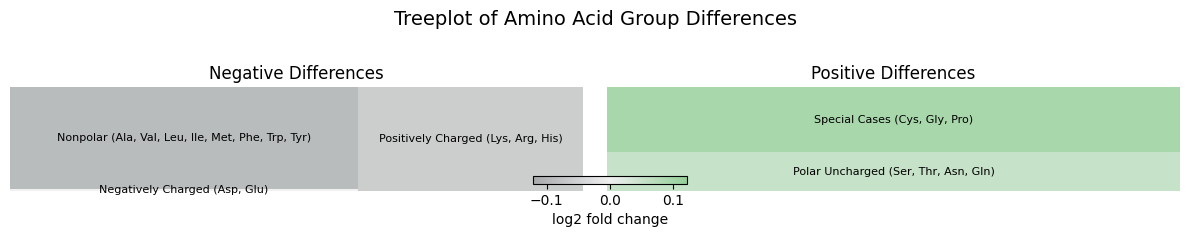

/tmp/ipykernel_181741/2495096539.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


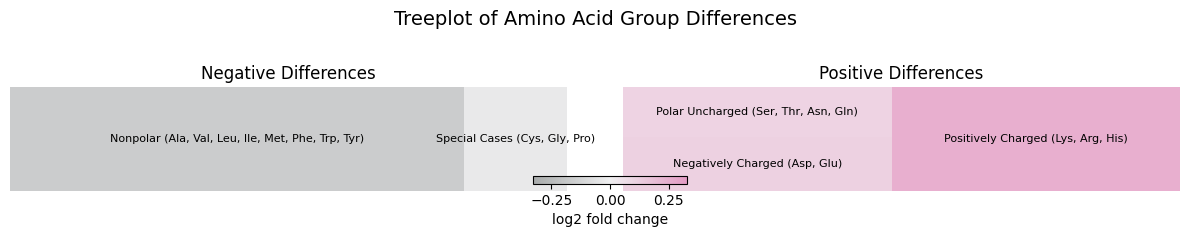

In [30]:
def plot_treemap_separated(df, second_color):
    df_pos = df[df['Difference'] > 0].copy()
    df_neg = df[df['Difference'] < 0].copy()
    
    df_pos['Size'] = df_pos['Difference'].abs()
    df_neg['Size'] = df_neg['Difference'].abs()
    
    max_abs_diff = max(df['Difference'].abs())
    norm = Normalize(vmin=-max_abs_diff, vmax=max_abs_diff)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    
    colors_cmap = ['#A7AAAA', "#EFEFF0", second_color]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_cmap, N=256)

    colors_pos = [cmap(norm(diff)) for diff in df_pos['Difference']]
    colors_neg = [cmap(norm(diff)) for diff in df_neg['Difference']]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 2))
    
    axes[0].set_title("Negative Differences", fontsize=12)
    squarify.plot(sizes=df_neg['Size'], label=df_neg['aa_groups'], color=colors_neg, 
                  alpha=0.8, ax=axes[0], text_kwargs={'fontsize': 8})
    axes[0].axis('off')
    
    axes[1].set_title("Positive Differences", fontsize=12)
    squarify.plot(sizes=df_pos['Size'], label=df_pos['aa_groups'], color=colors_pos, 
                  alpha=0.8, ax=axes[1], text_kwargs={'fontsize': 8})
    axes[1].axis('off')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
    cbar.set_label("log2 fold change", fontsize=10)
    
    plt.suptitle("Treeplot of Amino Acid Group Differences", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_treemap_separated(grouped0, second_color = "#94CE97")
plot_treemap_separated(grouped1, second_color = "#E39BC4")